In [1]:
import random
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import utils
import mask_vae
import u_net

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, List, Tuple, Type, Union
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from pathlib import Path
from torchvision.utils import make_grid, save_image
import copy
from torchvision.datasets import FashionMNIST

from torchmetrics import StructuralSimilarityIndexMeasure

cuda


# Mask VAE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
CONV = \
lambda in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, : \
    nn.Conv2d(in_channels, out_channels, kernel_size, stride  , padding  , bias=bias, padding_mode="reflect")
BATCH_NORM = nn.InstanceNorm2d
RELU = lambda : nn.LeakyReLU(negative_slope=0.2, inplace=True)
UPSAMPLE = lambda : Upsample([1,3,3,1])
DOWNSAMPLE = lambda : Downsample([1,3,3,1])
LAYERS = (1,1,1,1)
CHS_E = (32, 64, 128, 256)
CHS_D = (256, 128, 64, 32)
Z_DIM = 256

SSIM = StructuralSimilarityIndexMeasure(data_range=1, kernel_size=7).to(device)
LOSS = nn.L1Loss()

KLD_EPOCHS = 75

WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
DATA_DIR = '/content/drive/My Drive/Prostate_MRI/'
DATA_DIR = WORKING_DIR / "TrainingData"
CHECKPOINTS_DIR = WORKING_DIR / "vae_model_weights"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
PROGRESS_DIR = WORKING_DIR / "progress"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = WORKING_DIR / "vae_runs"
TENSORBOARD_LOGDIR.mkdir(parents=True, exist_ok=True)

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3
DISPLAY_FREQ = 5

OPTIMIZER = lambda parameters, lr : torch.optim.Adam(parameters, lr=lr, betas=(0.5,0.999))
MODE = transforms.InterpolationMode.BILINEAR

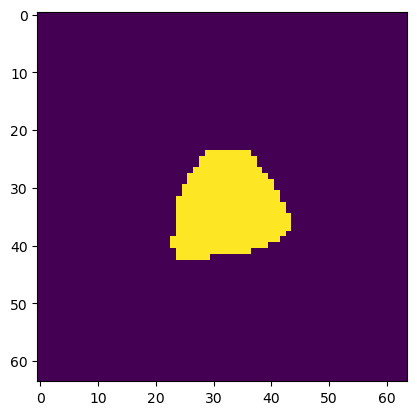

In [6]:
def lr_lambda(the_epoch):
    """Function for scheduling learning rate"""
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

# initialise model, optimiser
mask_vae_model = mask_vae.VAE(spade=False).to(device)
optimizer = OPTIMIZER(mask_vae_model.parameters(), lr = LEARNING_RATE)
# optimizer = torch.optim.SGD(vae_model.parameters(), lr = LEARNING_RATE, momentum=0.95, nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load training data and create DataLoader with batching and shuffling
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)


img = dataset[20][1][0]
plt.imshow(img)
plt.show()

In [7]:
x_real_img_train, x_real_mask_train = dataset[[10,20,50,60,100]]
x_real_img_train = x_real_img_train.to(device)
x_real_mask_train = x_real_mask_train.to(device)

x_real_img_valid, x_real_mask_valid = valid_dataset[[10,20,50,60,100]]
x_real_img_valid = x_real_img_valid.to(device)
x_real_mask_valid = x_real_mask_valid.to(device)

z_fixed = torch.randn(5, Z_DIM).to(device)

# training loop
best_loss = 1e8
best_weights = copy.deepcopy(vae_model.state_dict())

kld_epochs = KLD_EPOCHS
kld_nsteps = kld_epochs * len(dataloader)
nstep = 0
kld_weight = torch.sigmoid(torch.tensor(nstep*12/kld_nsteps - 6)).item()
ssim_weight = 0.5
for epoch in range(N_EPOCHS):
    current_train_loss = 0.0
    current_valid_loss = 0.0

    for images, masks in tqdm(dataloader, position=0): 
        images = images.to(device)
        masks = masks.to(device)
        # p = torch.rand((1,)).item()
        # if p > 0.4:
        #     inputs = torch.rot90(inputs, dims=(-2,-1))
        # if p > 0.6:
        #     inputs = torch.rot90(inputs, dims=(-2,-1))
        # if p > 0.8:
        #     inputs = torch.rot90(inputs, dims=(-2,-1))
        mask_vae_model.train()
        optimizer.zero_grad()
        recons, mu, logvar = vae_model(masks)  # forward pass
        # recons = recons/2.0 + 0.5
        loss = vae_loss(masks, recons, mu, logvar, kld_weight, ssim_weight)
        loss.backward()  # backpropagate loss
        current_train_loss += loss.item()
        optimizer.step()  # update weights

        nstep += 1
        kld_weight = torch.sigmoid(torch.tensor(nstep*12/kld_nsteps - 6)).item()
        
    # evaluate validation loss
    with torch.no_grad():
        vae_model.eval()
        for images, masks in tqdm(valid_dataloader, position=0):
            images = images.to(device)
            masks = masks.to(device)
            recons, mu, logvar = vae_model(masks)   # forward pass
            # recons = recons/2.0 + 0.5
            loss = vae_loss(masks, recons, mu, logvar, 1., ssim_weight)
            current_valid_loss += loss.item()

    epoch_train_loss = current_train_loss / len(dataloader)
    epoch_valid_loss = current_valid_loss / len(valid_dataloader)
    
    print(f"Epoch #{epoch} Loss/train {epoch_train_loss:.5f} | Loss/validation {epoch_valid_loss:.5f}")
    if epoch_valid_loss < best_loss:
        best_loss = epoch_valid_loss
        print("saving best model")
        best_weights = copy.deepcopy(vae_model.state_dict())
        torch.save(best_weights, CHECKPOINTS_DIR / "vae_model.pt")
    scheduler.step() # step the learning step scheduler

    # save examples of real/fake images
    if (epoch + 1) % DISPLAY_FREQ == 0:
        with torch.no_grad():
            x_recon_train = mask_vae_model(x_real_img_train, x_real_mask_train)[0]
            x_recon_valid = mask_vae_model(x_real_img_valid, x_real_mask_valid)[0]
            # x_recon = x_recon/2.0 + 0.5
            x_rand  = vae_model.generator(z_fixed, x_real_mask_valid)
            # x_rand = x_rand/2.0 + 0.5
            img_grid = make_grid(
                torch.cat([
                    x_real_img_train.cpu()[:5], 
                    x_recon_train.cpu()[:5],
                    x_real_img_valid.cpu()[:5], 
                    x_recon_valid.cpu()[:5], 
                    x_rand.cpu()[:5],
                ]), 
                nrow=5, 
                padding=12, 
                pad_value=-1, 
            )
            save_image(img_grid/2.0+0.5, PROGRESS_DIR / f"Real_fake_{(epoch+1):03d}.png")
            # img = (img_grid.numpy().transpose(1,2,0) + 1)/

TypeError: unsupported operand type(s) for //: 'list' and 'int'

# VAE

In [3]:
# to ensure reproducible training/validation split
random.seed(42)

# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
DATA_DIR = WORKING_DIR / "TrainingData"
CHECKPOINTS_DIR = WORKING_DIR / "vae_model_weights"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
PROGRESS_DIR = WORKING_DIR / "progress"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = WORKING_DIR / "vae_runs"
TENSORBOARD_LOGDIR.mkdir(parents=True, exist_ok=True)

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3
DISPLAY_FREQ = 5

# dimension of VAE latent space
Z_DIM = 256

In [4]:
# function to reduce the
def lr_lambda(the_epoch):
    """Function for scheduling learning rate"""
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
)


# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load training data and create DataLoader with batching and shuffling
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# initialise model, optimiser
vae_model = vae.VAE()# TODO 
optimizer = torch.optim.Adam(vae_model.parameters(), lr = LEARNING_RATE, betas=(0.0,0.9))# TODO 
# add a learning rate scheduler based on the lr_lambda function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda) # TODO




In [5]:
x_real = next(iter(valid_dataloader))
# training loop
writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary
for epoch in range(N_EPOCHS):
    current_train_loss = 0.0
    current_valid_loss = 0.0
    
    # TODO 
    # training iterations
    for inputs, labels in tqdm(dataloader, position=0):
        # needed to zero gradients in each iterations
        optimizer.zero_grad()
        recons, mu, logvar = vae_model(inputs)  # forward pass
        loss = vae.vae_loss(inputs, recons, mu, logvar)
        loss.backward()  # backpropagate loss
        current_train_loss += loss.item()
        optimizer.step()  # update weights
        
    # evaluate validation loss
    with torch.no_grad():
        vae_model.eval()
        for inputs in tqdm(valid_dataloader, position=0):
            recons, mu, logvar = vae_model(inputs)   # forward pass
            loss = vae.vae_loss(inputs, recons, mu, logvar)
            current_valid_loss += loss.item()
        
        vae_model.train()
    # write to tensorboard log
    writer.add_scalar("Loss/train", current_train_loss / len(dataloader), epoch)
    writer.add_scalar(
        "Loss/validation", current_valid_loss / len(valid_dataloader), epoch
    )
    print(f"Epoch #{epoch} Loss/train {current_train_loss / len(dataloader):.5f} | Loss/validation {current_valid_loss / len(valid_dataloader):.5f}")
    scheduler.step() # step the learning step scheduler

    # save examples of real/fake images
    if (epoch + 1) % DISPLAY_FREQ == 0:
        x_recon = vae_model(x_real)[0]
        img_grid = make_grid(
            torch.cat((x_recon[:5], x_real[:5])), nrow=5, padding=12, pad_value=-1
        )
        img = np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5
        writer.add_image(
            "Real_fake", img, epoch + 1,
        )
        plt.imsave(PROGRESS_DIR / f"Real_fake_{epoch:03d}.png", img[0])
    
    # TODO: sample noise  
    # TODO: generate images and display NEED TO BE ADDED

torch.save(vae_model.state_dict(), CHECKPOINTS_DIR / "vae_model.pth")

  0%|                                                                                           | 0/34 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16384 and 4096x512)

In [16]:
CHECKPOINTS_DIR = WORKING_DIR / "segmentation_model_weights"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = WORKING_DIR / "segmentation_runs"
TENSORBOARD_LOGDIR.mkdir(parents=True, exist_ok=True)

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
BATCH_SIZE = 32
N_EPOCHS = 100
LEARNING_RATE = 1e-4
TOLERANCE = 0.01  # for early stopping

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load training data and create DataLoader with batching and shuffling
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# initialise model, optimiser, and loss function
loss_function = utils.DiceBCELoss()
unet_model = u_net.UNet(num_classes=1)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)

minimum_valid_loss = 10  # initial validation loss
writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary

In [17]:
# training loop
for epoch in range(N_EPOCHS):
    current_train_loss = 0.0
    current_valid_loss = 0.0

    # training iterations
    # tqdm is for timing iteratiions
    for inputs, labels in tqdm(dataloader, position=0):
        # needed to zero gradients in each iterations
        optimizer.zero_grad()
        outputs = unet_model(inputs)  # forward pass
        loss = loss_function(outputs, labels.float())
        loss.backward()  # backpropagate loss
        current_train_loss += loss.item()
        optimizer.step()  # update weights

    # evaluate validation loss
    with torch.no_grad():
        unet_model.eval()  # turn off training option for evaluation
        for inputs, labels in tqdm(valid_dataloader, position=0):
            outputs = unet_model(inputs)  # forward pass
            loss = loss_function(outputs, labels.float())
            current_valid_loss += loss.item()

        unet_model.train()  # turn training back on

    # write to tensorboard log
    writer.add_scalar("Loss/train", current_train_loss / len(dataloader), epoch)
    writer.add_scalar(
        "Loss/validation", current_valid_loss / len(valid_dataloader), epoch
    )

    # if validation loss is improving, save model checkpoint
    # only start saving after 10 epochs
    if (current_valid_loss / len(valid_dataloader)) < minimum_valid_loss + TOLERANCE:
        minimum_valid_loss = current_valid_loss / len(valid_dataloader)
        if epoch > 9:
            torch.save(
                unet_model.cpu().state_dict(),
                CHECKPOINTS_DIR / f"u_net_{epoch}.pth",
            )

 47%|████▋     | 16/34 [01:07<01:20,  4.50s/it]

In [8]:
# directorys with data and to stored training checkpoints

# this is my best epoch - what is yours?
BEST_EPOCH = 30
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights" / f"u_net_{BEST_EPOCH}.pth"

# hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)

unet_model = u_net.UNet(num_classes=1)
unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR))
unet_model.eval()

..\..\..\Data


IndexError: list index out of range

In [ ]:
# TODO
# apply for all images and compute Dice score with ground-truth.
# output .mhd images with the predicted segmentations
with torch.no_grad():
    predict_index = 75
    (input, target) = valid_dataset[predict_index]
    output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
    prediction = torch.round(output)

    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(input[0], cmap="gray")
    ax[0].set_title("Input")
    ax[0].axis("off")

    ax[1].imshow(target[0])
    ax[1].set_title("Ground-truth")
    ax[1].axis("off")

    ax[2].imshow(prediction[0, 0])
    ax[2].set_title("Prediction")
    ax[2].axis("off")
    plt.show()